In [1]:
import csv
import requests
from bs4 import BeautifulSoup

# Make a GET request to the URL
url = "http://planetarynebulae.net/EN/page_np_resultat.php?id=372"
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the 6th table cell with colspan=3
td = soup.find_all('td', {'colspan': '3'})[5]

# Find the parent table of the td element
table = td.find_parent('table')

# Find all the rows in the table, starting from the 12th row
rows = table.find_all('tr')[12:]

# Create a new CSV file and write the table data to it
with open('output33.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the column headers to the CSV file
    headers = ['Name', 'Gal. Coord.', 'RA', 'DEC', 'Size', 'Statut']
    writer.writerow(headers)

    # Write the data rows to the CSV file
    for row in rows:
        # Extract the table cells from the row
        cells = row.find_all('td')
        # Write the cell values to the CSV file
        writer.writerow([cell.get_text(strip=True) for cell in cells])

In [12]:
import csv
import requests
from bs4 import BeautifulSoup

# Make a GET request to the URL
url = "http://planetarynebulae.net/EN/page_np_resultat.php?id=167"
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the 6th table cell with colspan=3
td = soup.find_all('td', {'colspan': '3'})[5]

# Find the parent table of the td element
table = td.find_parent('table')

# Find all the rows in the table, starting from the 12th row
rows = table.find_all('tr')[12:]

# Create a new CSV file and write the table data to it
with open('output33_version2.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    # Write the column headers to the CSV file
    headers = ['Name', 'Gal. Coord.', 'RA', 'DEC', 'Size', 'Statut']
    writer.writerow(headers)

    # Write the data rows to the CSV file
    for row in rows:
        # Extract the table cells from the row
        cells = row.find_all('td')
        # Write the cell values to the CSV file
        writer.writerow([cell.get_text(strip=True) for cell in cells])

In [1]:
import csv
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
import numpy as np
import cv2
from astropy.coordinates import Angle
from urllib.parse import urlencode
from sklearn.preprocessing import minmax_scale
import re
import requests


# Load and preprocess the images of the planetary nebulae
image_size = 512
fov_threshold = 0.7/60 # arc minutes/60 = degrees

images = []
with open('output33.csv', mode='r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader) # Skip the header row
    for row in csv_reader:
        ra = row[2]
        dec = row[3]
        fov_str = row[4]

        # Extract the numeric value from the FOV information string using regular expressions
        match = re.match(r'(\d+(\.\d+)?)', fov_str)
        fov = float(match.group(0))/60.0

        # Select only the objects with size > 0.7 arc min
        if fov > fov_threshold:
            # Convert RA and Dec to degrees
            ra_deg = Angle(ra, unit=u.hourangle).degree
            dec_deg = Angle(dec, unit=u.deg).degree

            # Convert the image size to pixels
            largeur = hauteur = image_size

            # Construct the request URL for the hips2fits service
            query_params={
                'hips':'DSS2 red',
                'ra':ra_deg,
                'dec':dec_deg,
                'fov':fov,
                'width':largeur,
                'height':hauteur
            }
            url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?{urlencode(query_params)}'

            # Download the image from the Aladin Sky Atlas server
            hdul = fits.open(url)
            image = hdul[0].data

            # Normalize the pixel values between 0 and 1
            image_min = np.min(image)
            image_max = np.max(image)
            image = (image - image_min) / (image_max - image_min)

            # Add the preprocessed image to the list of images
            images.append(image)

images = np.array(images)

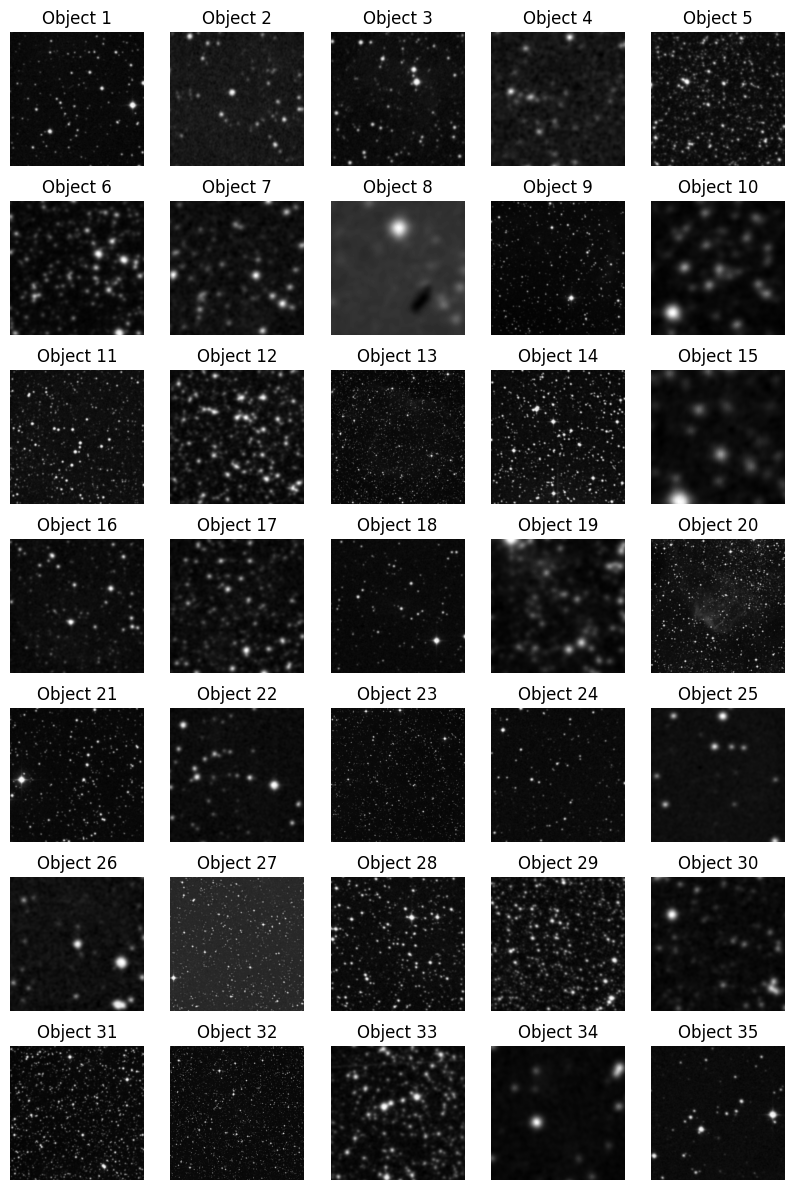

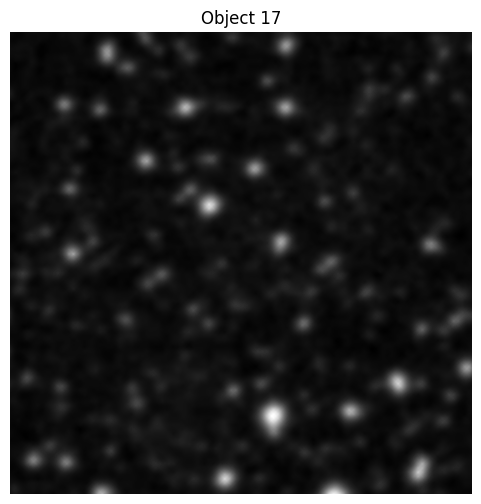

In [32]:
# Affichage des images
import matplotlib.pyplot as plt

# Create a figure with a 5x7 grid of subplots
fig, axs = plt.subplots(7, 5, figsize=(10, 15))
axs = axs.flatten()

# Loop over the first 35 images and plot them on the subplots
for i in range(35):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Object {i+1}')

# Show the 17th image in a bigger size
fig2, ax2 = plt.subplots(figsize=(6,6))
ax2.imshow(images[16], cmap='gray')
ax2.axis('off')
ax2.set_title('Object 17')

# Show the plots
plt.show()

In [4]:
import csv
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
import numpy as np
import cv2
from astropy.coordinates import Angle
from urllib.parse import urlencode
from sklearn.preprocessing import minmax_scale
import re
import requests
from astroquery.simbad import Simbad

Simbad.TIMEOUT = 240 # sets the timeout

# define the number of random positions to select
num_positions = 200

# randomly generate RA and Dec coordinates within a certain range
ra = np.random.uniform(low=0, high=360, size=num_positions)
dec = np.random.uniform(low=-90, high=90, size=num_positions)

# randomly select FOV values within the range of 0.7 to 20 arcminutes
fov_range = np.arange(0.7, 20, 0.1)/60 # arc minutes/60 = degrees
fov_choices = np.random.choice(fov_range, size=num_positions)

image_size = 128

not_images = []
for i in range(num_positions):
    ra_deg = ra[i]
    dec_deg = dec[i]

    fov = fov_choices[i]

    # define the resolution of the image
    largeur = 512
    hauteur = 512

    query_params={
        'hips':'DSS2 red',
        'ra':ra_deg,
        'dec':dec_deg,
        'fov':fov,
        'width':largeur,
        'height':hauteur
    }

    url = f'http://alasky.u-strasbg.fr/hips-image-services/hips2fits?{urlencode(query_params)}' 
    hdul = fits.open(url)
    image = hdul[0].data

    # normalize the pixel values between 0 and 1
    image_min = np.min(image)
    image_max = np.max(image)
    image = (image - image_min) / (image_max - image_min)

    # add the preprocessed image to the list of images
    not_images.append(image)
    
not_images = np.array(not_images)

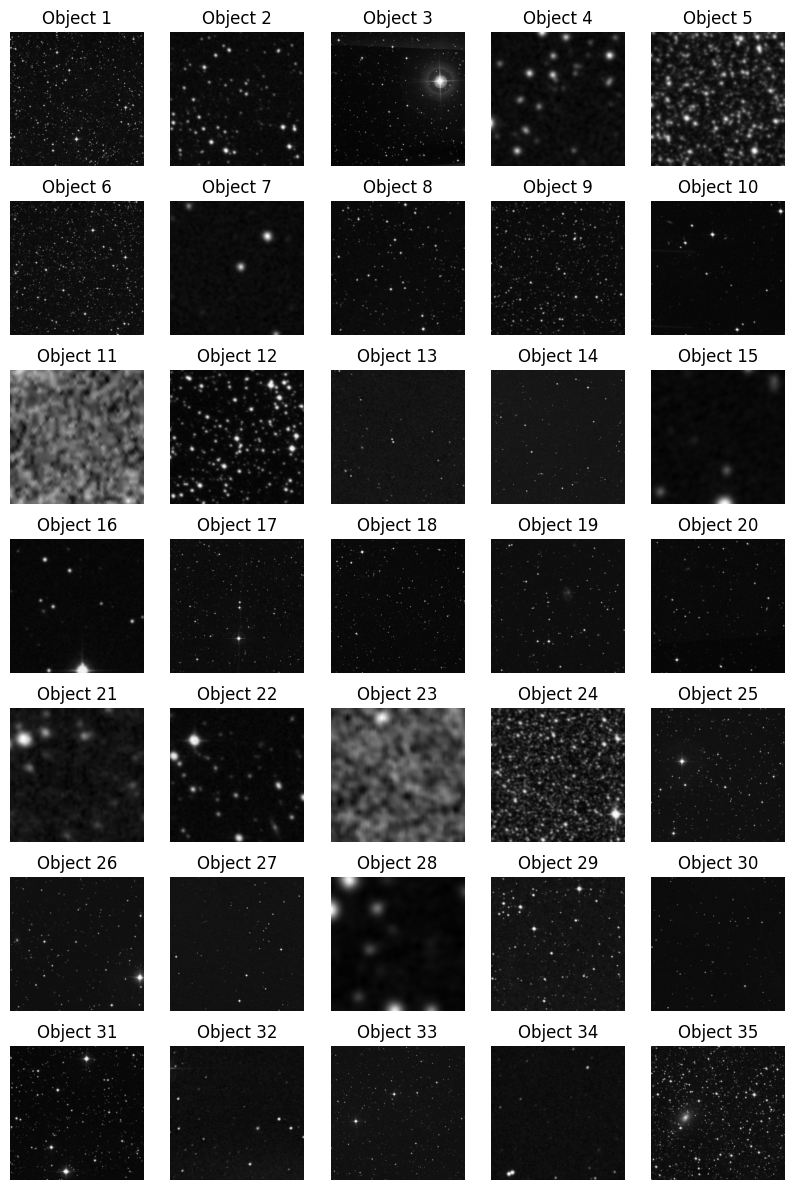

In [5]:
# affichage des images
import matplotlib.pyplot as plt

# create a figure with a 5x5 grid of subplots
fig, axs = plt.subplots(7, 5, figsize=(10, 15))
axs = axs.flatten()

# loop over the first 35 images and plot them on the subplots
for i in range(35):
    axs[i].imshow(not_images[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Object {i+1}')

# show the plot
plt.show()

(512, 512)


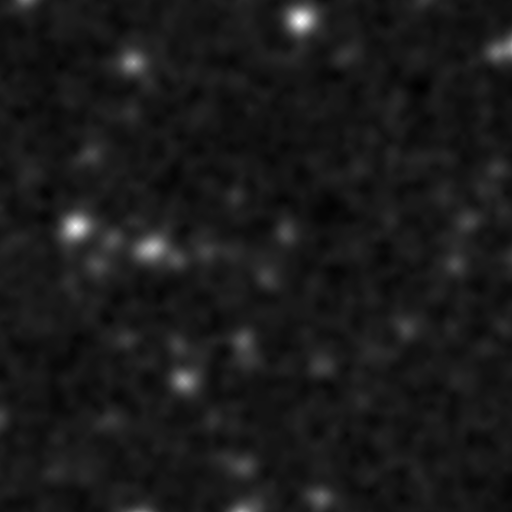

In [8]:
#préparation des données pour le traitememnt... 
from PIL import Image
import numpy as np

# Combine the two arrays into one numpy array
data = np.concatenate((images, not_images), axis=0)

# Create a numpy array of target values
targets = np.concatenate((np.ones(len(images)), np.zeros(len(not_images))))

# Convert to PIL image format
pil_images = [Image.fromarray((img * 255).astype('uint8'), 'L') for img in data]

# Check the size of the first image
print(pil_images[0].size)
display(pil_images[3])

In [10]:
#exportation du dataset

import numpy as np
from PIL import Image
import os

# Define the directory where the images will be saved
base_dir = "image_dataset"
os.makedirs(base_dir, exist_ok=True)

# Define the subdirectories for the classes
train_dir = os.path.join(base_dir, "train")
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(base_dir, "test")
os.makedirs(test_dir, exist_ok=True)

image_dir_train = os.path.join(train_dir, "images")
not_image_dir_train = os.path.join(train_dir, "not_images")
os.makedirs(image_dir_train, exist_ok=True)
os.makedirs(not_image_dir_train, exist_ok=True)

image_dir_test = os.path.join(test_dir, "images")
not_image_dir_test = os.path.join(test_dir, "not_images")
os.makedirs(image_dir_test, exist_ok=True)
os.makedirs(not_image_dir_test, exist_ok=True)

# Split the data into train and test sets
train_images = images[:int(0.8*len(images))]
test_images = images[int(0.8*len(images)):]

train_not_images = not_images[:int(0.8*len(not_images))]
test_not_images = not_images[int(0.8*len(not_images)):]

# Save the images to their respective directories
for i, img in enumerate(train_images):
    img_path = os.path.join(image_dir_train, f"image_{i}.jpg")
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    pil_img.save(img_path)

for i, img in enumerate(train_not_images):
    img_path = os.path.join(not_image_dir_train, f"not_image_{i}.jpg")
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    pil_img.save(img_path)

for i, img in enumerate(test_images):
    img_path = os.path.join(image_dir_test, f"image_{i}.jpg")
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    pil_img.save(img_path)

for i, img in enumerate(test_not_images):
    img_path = os.path.join(not_image_dir_test, f"not_image_{i}.jpg")
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    pil_img.save(img_path)

In [1]:
#modèle d'apprentissage profond

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import larq_compute_engine as lce
import tensorflow as tf
import larq as lq
from PIL import Image
import os

%matplotlib inline

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
  img=cv2.resize(img,(512,512))
  img=img/127.5-1
  return img

batch_size=8

#Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train',
                                                   target_size=(512, 512),
                                                   batch_size=batch_size)

validation_generator=val_datagen.flow_from_directory('image_dataset/test',
                                                      target_size=(512, 512),
                                                      batch_size=batch_size)

#Define the BNN classification model.


# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)


from tensorflow.keras import regularizers

model = tf.keras.models.Sequential([
    lq.layers.QuantConv2D(32, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(512, 512, 3),
                          kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Dropout(0.2),

    lq.layers.QuantConv2D(64, 3, padding="same", kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    lq.layers.QuantConv2D(128, 3, padding="same", kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Dropout(0.3),

    lq.layers.QuantConv2D(128, 3, padding="same", kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    lq.layers.QuantConv2D(256, 3, padding="same", kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Dropout(0.4),

    lq.layers.QuantConv2D(256, 3, padding="same", kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),

    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(128, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Dropout(0.5),

    lq.layers.QuantDense(2, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    tf.keras.layers.Activation("softmax")
])

#Compile the model.
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Save the model.
model.save("nebula.h5")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/50
33/33 [==============================] - 50s 706ms/step - loss: 1.7501 - accuracy: 0.5388 - val_loss: 14.6025 - val_accuracy: 0.3846
Epoch 2/50
33/33 [==============================] - 17s 507ms/step - loss: 1.7197 - accuracy: 0.5039 - val_loss: 8.9135 - val_accuracy: 0.3846
Epoch 3/50
33/33 [==============================] - 18s 524ms/step - loss: 1.6948 - accuracy: 0.5620 - val_loss: 10.0240 - val_accuracy: 0.3846
Epoch 4/50
33/33 [==============================] - 18s 529ms/step - loss: 1.6822 - accuracy: 0.6085 - val_loss: 6.2179 - val_accuracy: 0.3846
Epoch 5/50
33/33 [==============================] - 18s 550ms/step - loss: 1.6668 - accuracy: 0.6318 - val_loss: 8.0648 - val_accuracy: 0.3846
Epoch 6/50
33/33 [==============================] - 19s 561ms/step - loss: 1.6593 - accuracy: 0.5930

KeyboardInterrupt: 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/50
9/9 [==============================] - 41s 648ms/step - loss: 0.7920 - accuracy: 0.5659 - val_loss: 4.1170 - val_accuracy: 0.4615 - lr: 5.0000e-05
Epoch 2/50
9/9 [==============================] - 4s 469ms/step - loss: 0.6732 - accuracy: 0.6008 - val_loss: 4.5431 - val_accuracy: 0.4462 - lr: 5.0000e-05
Epoch 3/50
9/9 [==============================] - 5s 510ms/step - loss: 0.6797 - accuracy: 0.6085 - val_loss: 6.7889 - val_accuracy: 0.4000 - lr: 5.0000e-05
Epoch 4/50
9/9 [==============================] - 6s 612ms/step - loss: 0.6236 - accuracy: 0.6357 - val_loss: 5.3633 - val_accuracy: 0.4154 - lr: 5.0000e-05
Epoch 5/50
9/9 [==============================] - 5s 483ms/step - loss: 0.5747 - accuracy: 0.6938 - val_loss: 5.0828 - val_accuracy: 0.4154 - lr: 5.0000e-05
Epoch 6/50
9/9 [===============

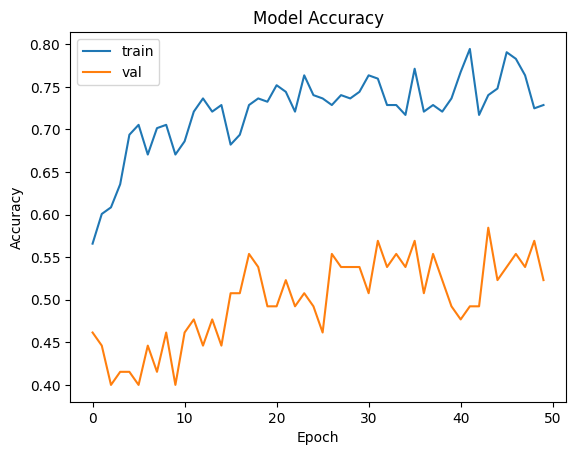

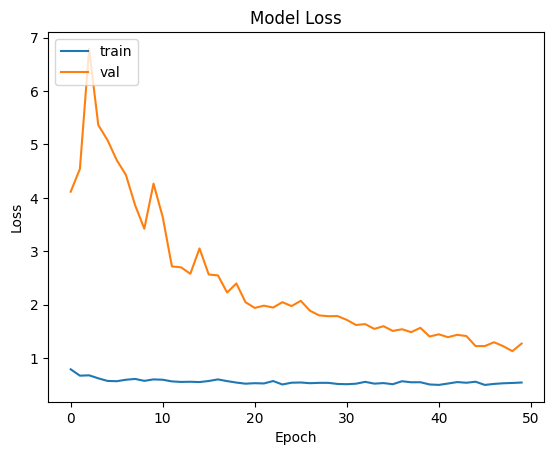

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import larq_compute_engine as lce
import tensorflow as tf
import larq as lq
from PIL import Image
import os

%matplotlib inline

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
  img=cv2.resize(img,(256,256))
  img=img/127.5-1
  return img

#Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train')
validation_generator=val_datagen.flow_from_directory('image_dataset/test')

#Define the BNN classification model.


# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)


model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(64, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(256, 256, 3)), # modify the input shape to match the desired resolution
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(64, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(64, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    lq.layers.QuantDense(2, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")])

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr / 10
    return lr

#Compile the model.
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model with the learning rate scheduler
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Save the model.
model.save("nebula.h5")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/100
33/33 [==============================] - 36s 753ms/step - loss: 0.7628 - accuracy: 0.5426 - val_loss: 0.6578 - val_accuracy: 0.6154 - lr: 5.0000e-05
Epoch 2/100
33/33 [==============================] - 19s 569ms/step - loss: 0.7110 - accuracy: 0.6047 - val_loss: 0.6485 - val_accuracy: 0.6154 - lr: 5.0000e-05
Epoch 3/100
33/33 [==============================] - 19s 560ms/step - loss: 0.6935 - accuracy: 0.6163 - val_loss: 0.6419 - val_accuracy: 0.6154 - lr: 5.0000e-05
Epoch 4/100
33/33 [==============================] - 20s 602ms/step - loss: 0.7100 - accuracy: 0.5581 - val_loss: 0.6418 - val_accuracy: 0.6154 - lr: 5.0000e-05
Epoch 5/100
33/33 [==============================] - 21s 636ms/step - loss: 0.6862 - accuracy: 0.5775 - val_loss: 0.6315 - val_accuracy: 0.6308 - lr: 5.0000e-05
Epoch 6/100


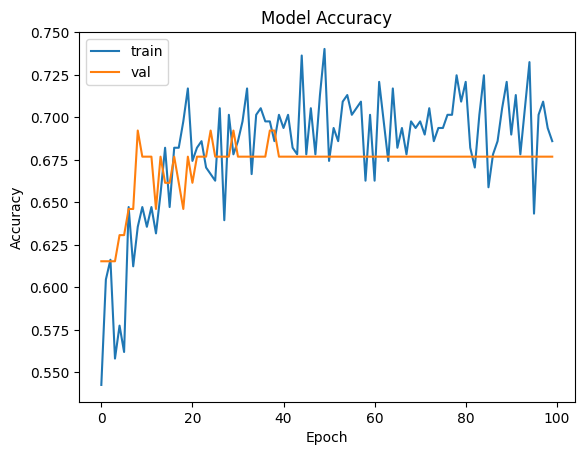

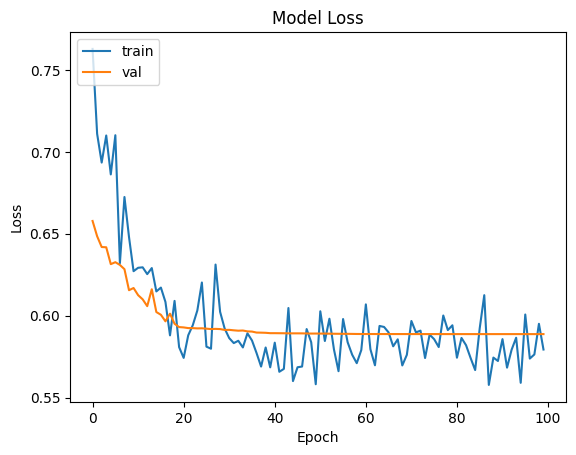

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import os

%matplotlib inline

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train',
                                                   target_size=(512, 512),
                                                   batch_size=batch_size)

validation_generator=val_datagen.flow_from_directory('image_dataset/test',
                                                      target_size=(512, 512),
                                                      batch_size=batch_size)

# Define the neural network model using a pre-trained VGG16 model.
base_model = tf.keras.applications.VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr / 10
    return lr

# Compile the model.
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train the model with the learning rate scheduler
history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Save the model.
model.save("nebula.h5")

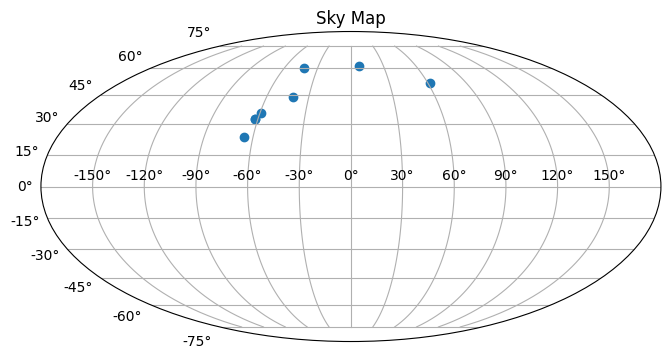

In [13]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('output33_version2.csv')

# Convert the RA and DEC columns to astropy SkyCoord objects
coords = SkyCoord(df['RA'], df['DEC'], unit=(u.hourangle, u.deg))

# Plot the coordinates on a sky map
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(coords.ra.wrap_at(180*u.deg).radian, coords.dec.radian)
ax.grid(True)
plt.title('Sky Map')
plt.show()

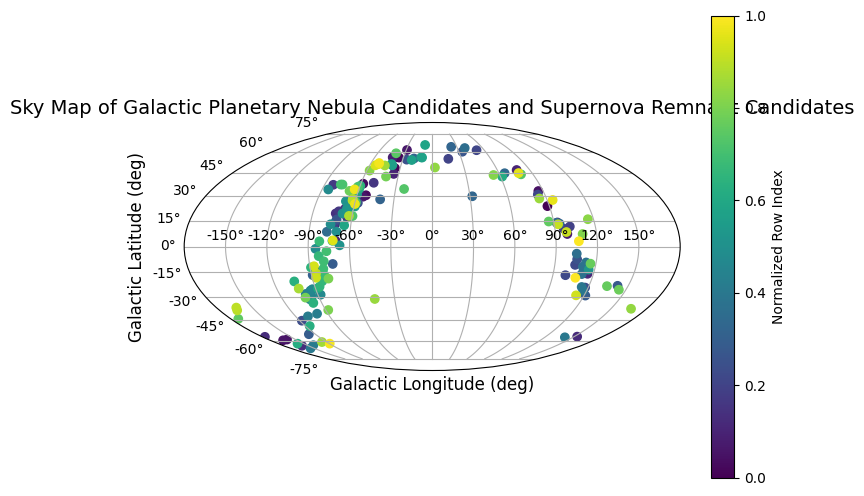

In [14]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('output33.csv')

# Convert the RA and DEC columns to astropy SkyCoord objects
coords = SkyCoord(df['RA'], df['DEC'], unit=(u.hourangle, u.deg))

# Normalize the row index of the DataFrame
norm_index = np.arange(len(df)) / (len(df) - 1)

# Set up a colormap to map normalized row index to color
cmap = plt.get_cmap('viridis')

# Plot the coordinates on a sky map, with colors based on normalized row index
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
scat = ax.scatter(coords.ra.wrap_at(180*u.deg).radian, coords.dec.radian, c=norm_index, cmap=cmap)
ax.grid(True)

# Add a colorbar to the sky map
cb = plt.colorbar(scat)
cb.set_label('Normalized Row Index', fontsize=10)

# Add labels for the galactic longitude and latitude
ax.set_xlabel('Galactic Longitude (deg)', fontsize=12)
ax.set_ylabel('Galactic Latitude (deg)', fontsize=12)

# Add a title to the sky map
plt.title('Sky Map of Galactic Planetary Nebula Candidates and Supernova Remnant Candidates', fontsize=14)

# Show the sky map
plt.show()

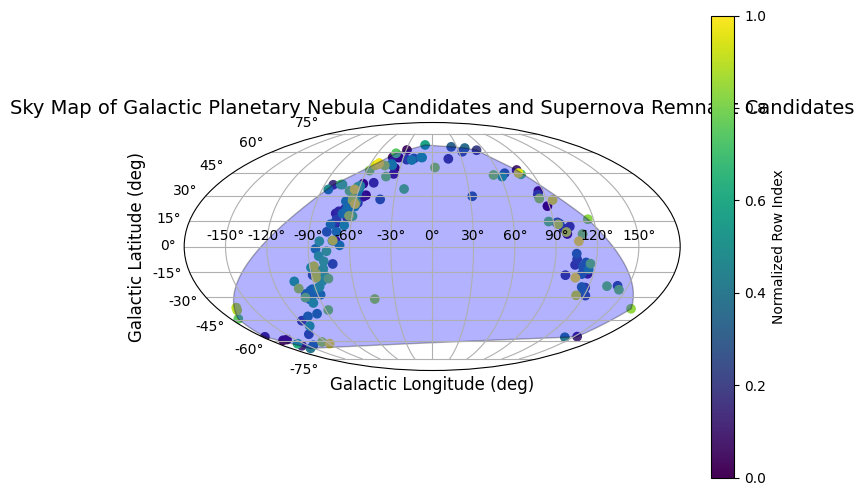

In [18]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('output33.csv')

# Convert the RA and DEC columns to astropy SkyCoord objects
coords = SkyCoord(df['RA'], df['DEC'], unit=(u.hourangle, u.deg))

# Normalize the row index of the DataFrame
norm_index = np.arange(len(df)) / (len(df) - 1)

# Set up a colormap to map normalized row index to color
cmap = plt.get_cmap('viridis')

# Plot the coordinates on a sky map, with colors based on normalized row index
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='mollweide')
scat = ax.scatter(coords.ra.wrap_at(180*u.deg).radian, coords.dec.radian, c=norm_index, cmap=cmap)
ax.grid(True)

# Compute the convex hull of the plotted points with higher precision
points = np.array([coords.ra.wrap_at(180*u.deg).radian, coords.dec.radian]).T
hull = ConvexHull(points, qhull_options="QbB Qt")

# Plot the convex hull as a closed polygon
hull_poly = plt.Polygon(points[hull.vertices], alpha=0.3, edgecolor='black', facecolor='blue')
ax.add_patch(hull_poly)

# Add a colorbar to the sky map
cb = plt.colorbar(scat)
cb.set_label('Normalized Row Index', fontsize=10)

# Add labels for the galactic longitude and latitude
ax.set_xlabel('Galactic Longitude (deg)', fontsize=12)
ax.set_ylabel('Galactic Latitude (deg)', fontsize=12)

# Add a title to the sky map
plt.title('Sky Map of Galactic Planetary Nebula Candidates and Supernova Remnant Candidates', fontsize=14)

# Show the sky map
plt.show()

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import os

%matplotlib inline

batch_size = 8

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train',
                                                   target_size=(512, 512),
                                                   batch_size=batch_size)

validation_generator=val_datagen.flow_from_directory('image_dataset/test',
                                                      target_size=(512, 512),
                                                      batch_size=batch_size)

# Define the base VGG16 model.
base_model = tf.keras.applications.VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

# Fine-tuning parameters
learning_rates = [0.0001, 0.00005, 0.00001]
dropout_rates = [0.4, 0.5, 0.6]

best_val_accuracy = 0
best_params = {}

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr / 10
    return lr

for lr in learning_rates:
    for dr in dropout_rates:
        # Reset the base model weights.
        base_model.trainable = False
        base_model.set_weights(base_model.get_weights())

        # Construct the model with the current fine-tuning parameters.
        model = tf.keras.models.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

        # Compile the model
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model with the learning rate scheduler
        history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

        # Evaluate current fine-tuning parameters
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}

            # Save the model with the best validation accuracy.
            model.save("nebula_best.h5")

print("Best validation accuracy:", best_val_accuracy)
print("Best fine-tuning parameters:", best_params)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/100
33/33 [==============================] - 59s 900ms/step - loss: 0.7500 - accuracy: 0.5620 - val_loss: 0.6583 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 2/100
33/33 [==============================] - 33s 996ms/step - loss: 0.6690 - accuracy: 0.6163 - val_loss: 0.6929 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 3/100
33/33 [==============================] - 23s 688ms/step - loss: 0.6659 - accuracy: 0.6085 - val_loss: 0.6226 - val_accuracy: 0.6769 - lr: 1.0000e-04
Epoch 4/100
33/33 [==============================] - 21s 644ms/step - loss: 0.6124 - accuracy: 0.6550 - val_loss: 0.6202 - val_accuracy: 0.6615 - lr: 1.0000e-04
Epoch 5/100
33/33 [==============================] - 21s 638ms/step - loss: 0.6395 - accuracy: 0.6279 - val_loss: 0.6171 - val_accuracy: 0.6769 - lr: 1.0000e-04
Epoch 6/100


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/100
33/33 [==============================] - 22s 642ms/step - loss: 0.7793 - accuracy: 0.5116 - val_loss: 0.6524 - val_accuracy: 0.6154 - lr: 5.0000e-04
Epoch 2/100
33/33 [==============================] - 21s 628ms/step - loss: 0.7329 - accuracy: 0.5465 - val_loss: 0.6588 - val_accuracy: 0.6154 - lr: 5.0000e-04
Epoch 3/100
33/33 [==============================] - 21s 635ms/step - loss: 0.6746 - accuracy: 0.6318 - val_loss: 0.6558 - val_accuracy: 0.6923 - lr: 5.0000e-04
Epoch 4/100
33/33 [==============================] - 21s 645ms/step - loss: 0.6755 - accuracy: 0.6163 - val_loss: 0.6326 - val_accuracy: 0.6615 - lr: 5.0000e-04
Epoch 5/100
33/33 [==============================] - 21s 638ms/step - loss: 0.6755 - accuracy: 0.5853 - val_loss: 0.6292 - val_accuracy: 0.6615 - lr: 5.0000e-04
Epoch 6/100


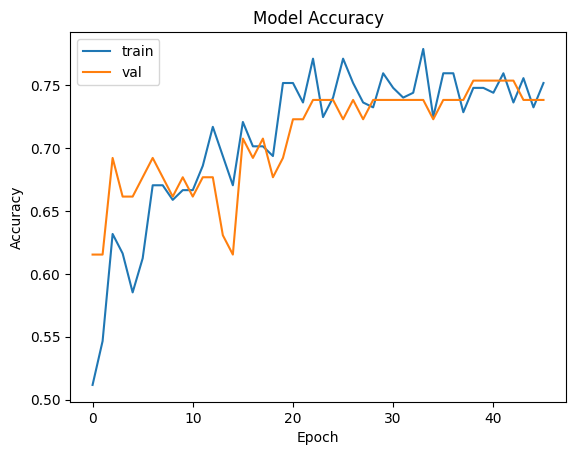

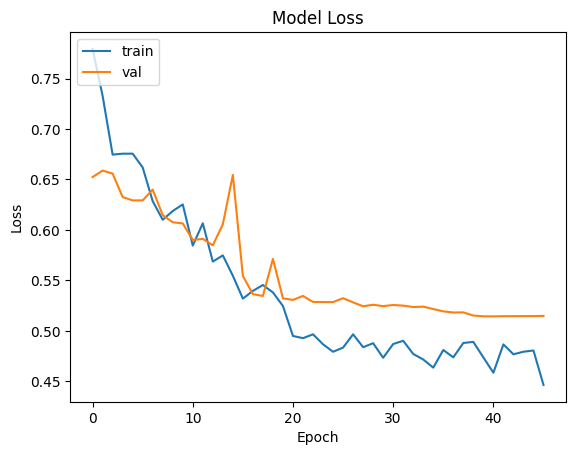

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import os

%matplotlib inline

batch_size = 8

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train',
                                                   target_size=(512, 512),
                                                   batch_size=batch_size)

validation_generator=val_datagen.flow_from_directory('image_dataset/test',
                                                      target_size=(512, 512),
                                                      batch_size=batch_size)

# Define the base VGG16 model.
base_model = tf.keras.applications.VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

# Fine-tuning parameters
learning_rates = [0.0005]
dropout_rates = [0.4]

best_val_accuracy = 0
best_params = {}

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        lr = lr / 10
    return lr

for lr in learning_rates:
    for dr in dropout_rates:
        # Reset the base model weights.
        base_model.trainable = False
        base_model.set_weights(base_model.get_weights())

        # Construct the model with the current fine-tuning parameters.
        model = tf.keras.models.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

        # Compile the model
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model with the learning rate scheduler
        history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

        # Evaluate current fine-tuning parameters
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}

            # Save the model with the best validation accuracy.
            model.save("nebula_best.h5")

print("Best validation accuracy:", best_val_accuracy)
print("Best fine-tuning parameters:", best_params)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/100
33/33 [==============================] - 62s 911ms/step - loss: 0.8129 - accuracy: 0.5736 - val_loss: 0.6934 - val_accuracy: 0.3538 - lr: 5.0000e-04
Epoch 2/100
33/33 [==============================] - 22s 666ms/step - loss: 0.7056 - accuracy: 0.5620 - val_loss: 0.6554 - val_accuracy: 0.6154 - lr: 5.0000e-04
Epoch 3/100
33/33 [==============================] - 27s 827ms/step - loss: 0.7036 - accuracy: 0.5620 - val_loss: 0.6524 - val_accuracy: 0.6769 - lr: 5.0000e-04
Epoch 4/100
33/33 [==============================] - 22s 652ms/step - loss: 0.6878 - accuracy: 0.5698 - val_loss: 0.6453 - val_accuracy: 0.6615 - lr: 5.0000e-04
Epoch 5/100
33/33 [==============================] - 20s 614ms/step - loss: 0.6463 - accuracy: 0.6357 - val_loss: 0.6241 - val_accuracy: 0.6615 - lr: 5.0000e-04
Epoch 6/100


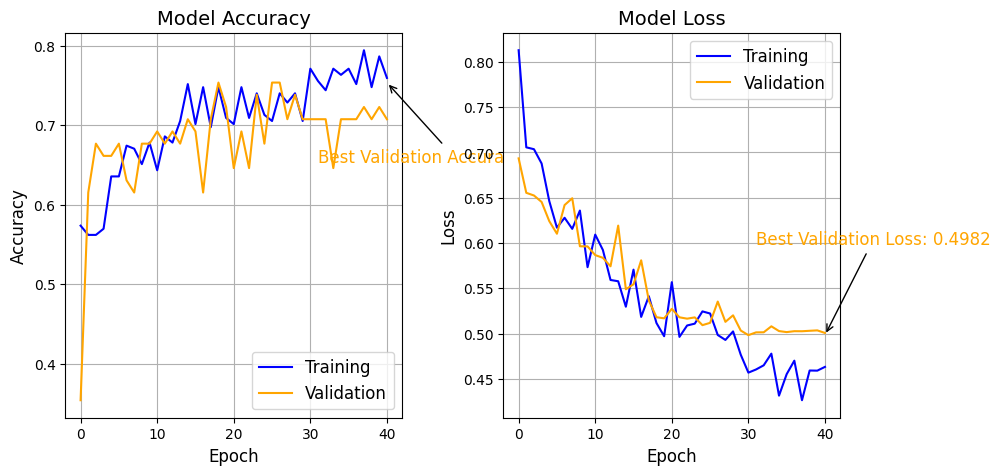

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import os

%matplotlib inline

batch_size = 8

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train',
                                                   target_size=(512, 512),
                                                   batch_size=batch_size)

validation_generator=val_datagen.flow_from_directory('image_dataset/test',
                                                      target_size=(512, 512),
                                                      batch_size=batch_size)

# Define the base VGG16 model.
base_model = tf.keras.applications.VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

# Fine-tuning parameters
learning_rates = [0.0005]
dropout_rates = [0.4]

best_val_accuracy = 0
best_params = {}

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 30 == 0 and epoch != 0:
        lr = lr / 10
    return lr

for lr in learning_rates:
    for dr in dropout_rates:
        # Reset the base model weights.
        base_model.trainable = False
        base_model.set_weights(base_model.get_weights())

        # Construct the model with the current fine-tuning parameters.
        model = tf.keras.models.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

        # Compile the model
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model with the learning rate scheduler
        history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

        # Evaluate current fine-tuning parameters
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}

            # Save the model with the best validation accuracy.
            model.save("nebula_best2.h5")

print("Best validation accuracy:", best_val_accuracy)
print("Best fine-tuning parameters:", best_params)

# Set figure size
fig = plt.figure(figsize=(10, 5))

# Plot the training and validation accuracy
ax1 = fig.add_subplot(121)
ax1.plot(history.history['accuracy'], color='blue')
ax1.plot(history.history['val_accuracy'], color='orange')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(['Training', 'Validation'], loc='lower right', fontsize=12)
ax1.grid(True)

# Add text annotation for best accuracy
best_val_acc = max(history.history['val_accuracy'])
ax1.annotate(f'Best Validation Accuracy: {best_val_acc:.4f}',
             xy=(len(history.history['val_accuracy']) - 1, best_val_acc),
             xytext=(len(history.history['val_accuracy']) - 10, best_val_acc - 0.1),
             fontsize=12,
             color='orange',
             arrowprops=dict(facecolor='orange', arrowstyle='->'))

# Plot the training and validation loss
ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'], color='blue')
ax2.plot(history.history['val_loss'], color='orange')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.legend(['Training', 'Validation'], loc='upper right', fontsize=12)
ax2.grid(True)

# Add text annotation for best loss
best_val_loss = min(history.history['val_loss'])
ax2.annotate(f'Best Validation Loss: {best_val_loss:.4f}',
             xy=(len(history.history['val_loss']) - 1, best_val_loss),
             xytext=(len(history.history['val_loss']) - 10, best_val_loss + 0.1),
             fontsize=12,
             color='orange',
             arrowprops=dict(facecolor='orange', arrowstyle='->'))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()

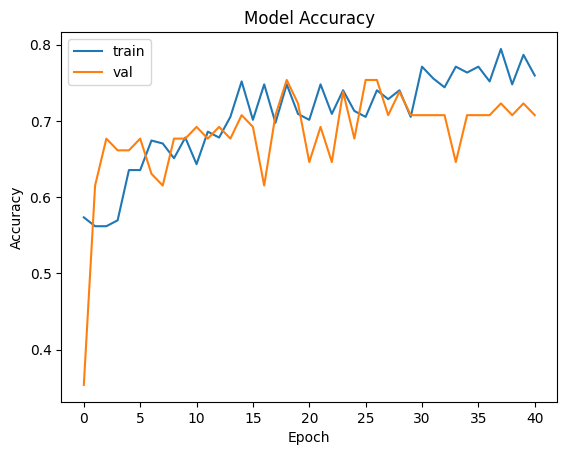

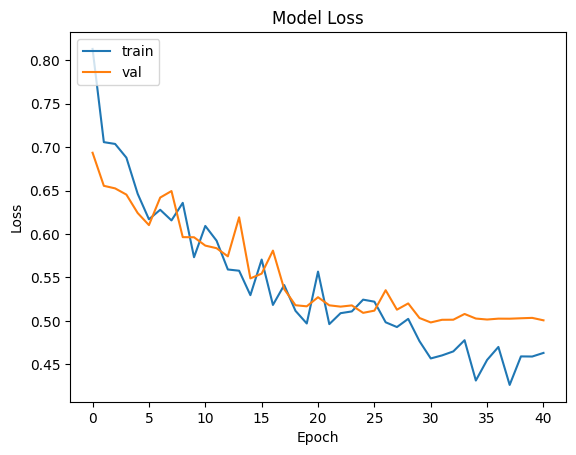

In [2]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 258 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Epoch 1/100
33/33 [==============================] - 22s 629ms/step - loss: 0.7885 - accuracy: 0.5310 - val_loss: 0.6356 - val_accuracy: 0.6615 - lr: 5.0000e-04
Epoch 2/100
33/33 [==============================] - 21s 639ms/step - loss: 0.6415 - accuracy: 0.6744 - val_loss: 0.6337 - val_accuracy: 0.6615 - lr: 5.0000e-04
Epoch 3/100
33/33 [==============================] - 22s 655ms/step - loss: 0.6395 - accuracy: 0.6550 - val_loss: 0.6226 - val_accuracy: 0.6462 - lr: 5.0000e-04
Epoch 4/100
33/33 [==============================] - 21s 641ms/step - loss: 0.5981 - accuracy: 0.7248 - val_loss: 0.6065 - val_accuracy: 0.6462 - lr: 5.0000e-04
Epoch 5/100
33/33 [==============================] - 21s 644ms/step - loss: 0.6173 - accuracy: 0.6822 - val_loss: 0.6157 - val_accuracy: 0.6462 - lr: 5.0000e-04
Epoch 6/100


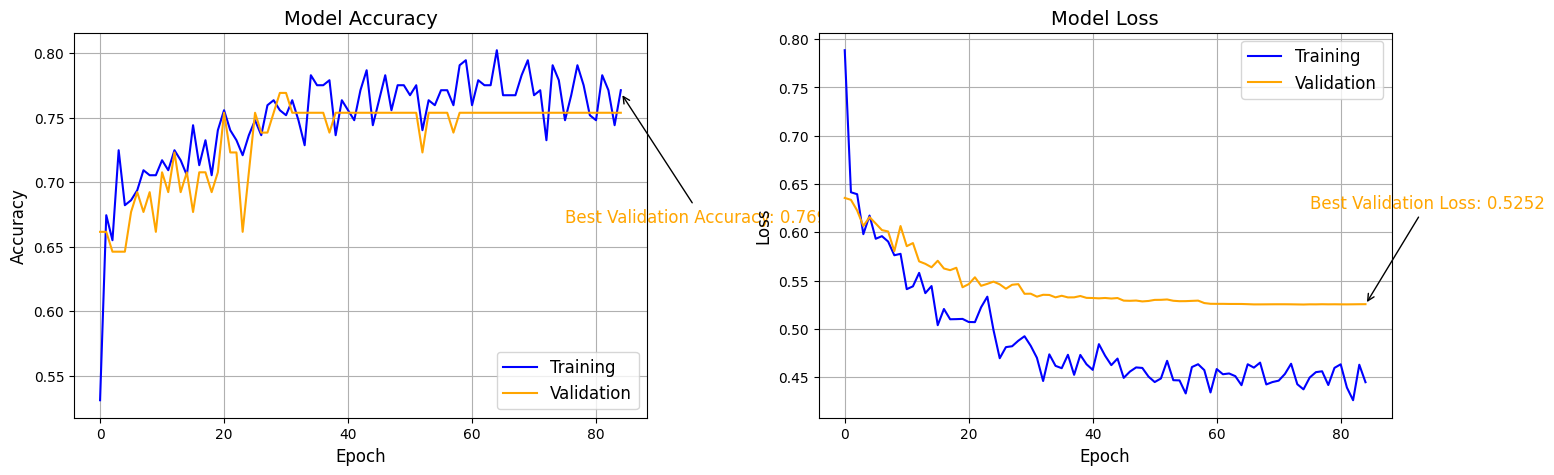

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image
import os

%matplotlib inline

batch_size = 8

# Define the strategy to use multiple GPUs.
strategy = tf.distribute.MirroredStrategy()

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Defining data generators.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('image_dataset/train',
                                                   target_size=(512, 512),
                                                   batch_size=batch_size)

validation_generator=val_datagen.flow_from_directory('image_dataset/test',
                                                      target_size=(512, 512),
                                                      batch_size=batch_size)

# Define the base VGG16 model.
base_model = tf.keras.applications.VGG16(input_shape=(512, 512, 3), include_top=False, weights='imagenet')

# Fine-tuning parameters
learning_rates = [0.0005]
dropout_rates = [0.4]

best_val_accuracy = 0
best_params = {}

# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 30 == 0 and epoch != 0:
        lr = lr / 10
    return lr

for lr in learning_rates:
    for dr in dropout_rates:
        # Reset the base model weights.
        base_model.trainable = False
        base_model.set_weights(base_model.get_weights())

        # Construct the model with the current fine-tuning parameters.
        model = tf.keras.models.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(dr),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

        # Compile the model
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=lr),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )

        # Train the model with the learning rate scheduler
        history = model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

        """
        # Fine-tune the base model
        base_model.trainable = True
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=lr/10),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        history_fine_tune = model.fit(train_generator, epochs=10, validation_data=validation_generator)
        """
        # Evaluate current fine-tuning parameters
        val_accuracy = max(history.history['val_accuracy'])
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}

            # Save the model with the best validation accuracy.
            model.save("nebula_best2.h5")

print("Best validation accuracy:", best_val_accuracy)
print("Best fine-tuning parameters:", best_params)

# Set figure size
fig = plt.figure(figsize=(17, 5))

# Plot the training and validation accuracy
ax1 = fig.add_subplot(121)
ax1.plot(history.history['accuracy'], color='blue')
ax1.plot(history.history['val_accuracy'], color='orange')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.legend(['Training', 'Validation'], loc='lower right', fontsize=12)
ax1.grid(True)

# Add text annotation for best accuracy
best_val_acc = max(history.history['val_accuracy'])
ax1.annotate(f'Best Validation Accuracy: {best_val_acc:.4f}',
             xy=(len(history.history['val_accuracy']) - 1, best_val_acc),
             xytext=(len(history.history['val_accuracy']) - 10, best_val_acc - 0.1),
             fontsize=12,
             color='orange',
             arrowprops=dict(facecolor='orange', arrowstyle='->'))

# Plot the training and validation loss
ax2 = fig.add_subplot(122)
ax2.plot(history.history['loss'], color='blue')
ax2.plot(history.history['val_loss'], color='orange')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.legend(['Training', 'Validation'], loc='upper right', fontsize=12)
ax2.grid(True)

# Add text annotation for best loss
best_val_loss = min(history.history['val_loss'])
ax2.annotate(f'Best Validation Loss: {best_val_loss:.4f}',
             xy=(len(history.history['val_loss']) - 1, best_val_loss),
             xytext=(len(history.history['val_loss']) - 10, best_val_loss + 0.1),
             fontsize=12,
             color='orange',
             arrowprops=dict(facecolor='orange', arrowstyle='->'))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()

In [3]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 8

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Load the saved model with the best validation accuracy
model = tf.keras.models.load_model("nebula_best2.h5")

# Define the data generator for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'image_dataset/test',
    target_size=(512, 512),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print("Test accuracy:", test_accuracy)

Found 65 images belonging to 2 classes.
9/9 [==============================] - 3s 285ms/step - loss: 0.5256 - accuracy: 0.7538
Test accuracy: 0.7538461685180664


In [4]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 8

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Load the saved model with the best validation accuracy
model = tf.keras.models.load_model("nebula_best2.h5")

# Define the data generator for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'image_dataset/test',
    target_size=(512, 512),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Make predictions on the test set
test_predictions = model.predict(test_generator)

# Get the predicted class labels
test_predicted_labels = np.argmax(test_predictions, axis=-1)

# Load the true labels for the test set
test_true_labels = test_generator.classes

# Calculate the accuracy of the predictions
accuracy = np.mean(test_predicted_labels == test_true_labels)

# Print the accuracy
print("Accuracy:", accuracy)

Found 65 images belonging to 2 classes.
9/9 [==============================] - 3s 332ms/step
Accuracy: 0.7538461538461538


In [14]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 8

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Load the saved model with the best validation accuracy
model = tf.keras.models.load_model("nebula_best2.h5")

# Define the data generator for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'image_dataset/test',
    target_size=(512, 512),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Get the predicted labels for the test set
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=-1)

# Get the true labels for the test set
test_true_labels = test_generator.classes

# Calculate the accuracy of the model for the positive class
positive_class_index = 0
positive_class_mask = test_true_labels == positive_class_index
positive_class_accuracy = np.mean(test_predicted_labels[positive_class_mask] == test_true_labels[positive_class_mask])

# Print the accuracy of the model for the positive class
print("Positive class accuracy:", positive_class_accuracy)

Found 65 images belonging to 2 classes.
9/9 [==============================] - 3s 333ms/step
Positive class accuracy: 0.68


Found 65 images belonging to 2 classes.
9/9 [==============================] - 3s 342ms/step


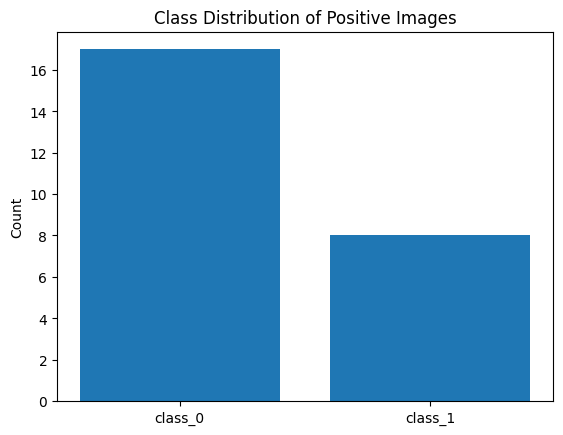

In [16]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

batch_size = 8

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Load the saved model with the best validation accuracy
model = tf.keras.models.load_model("nebula_best2.h5")

# Define the data generator for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'image_dataset/test',
    target_size=(512, 512),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

# Get the predicted labels for the test set
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=-1)

# Get the true labels for the test set
test_true_labels = test_generator.classes

# Create a list of positive class image filenames and predicted labels
positive_class_index = 0
positive_filenames = [filename for i, filename in enumerate(test_generator.filenames) if test_true_labels[i] == positive_class_index]
positive_predicted_labels = test_predicted_labels[positive_class_mask]

# Calculate the class distribution for the positive images
unique_classes, counts = np.unique(positive_predicted_labels, return_counts=True)
class_distribution = {class_names[class_idx]: count for class_idx, count in zip(unique_classes, counts)}

# Plot a bar chart of the class distribution
plt.bar(range(len(class_distribution)), list(class_distribution.values()), align='center')
plt.xticks(range(len(class_distribution)), list(class_distribution.keys()))
plt.ylabel('Count')
plt.title('Class Distribution of Positive Images')
plt.show()

Found 13 images belonging to 1 classes.
2/2 [==============================] - 8s 8s/step
{'images': 0}


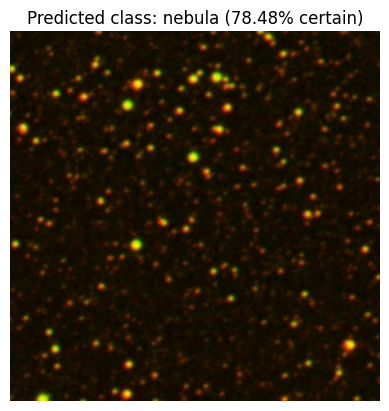

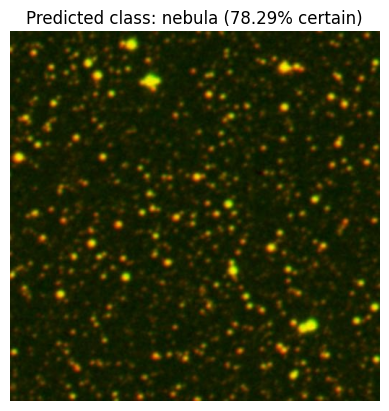

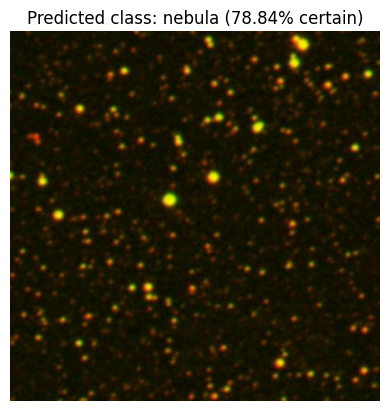

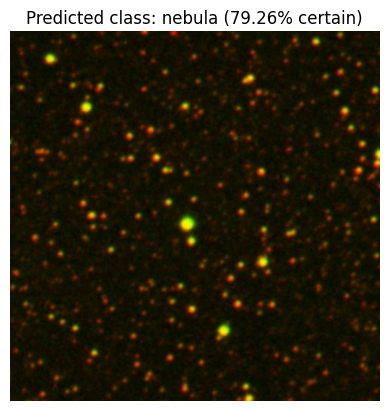

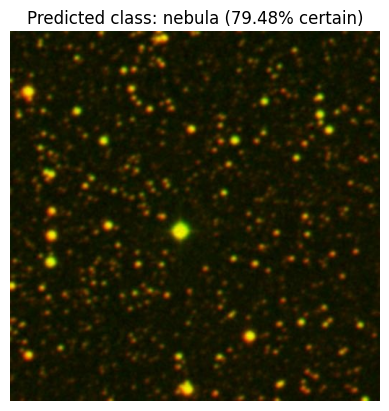

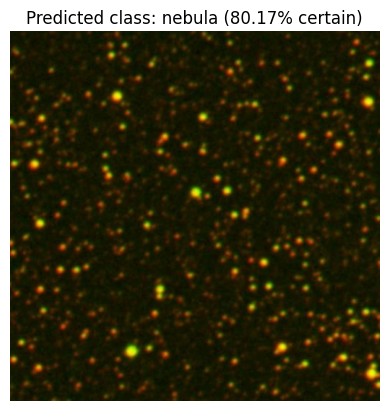

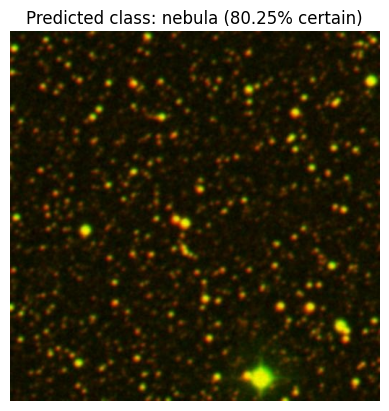

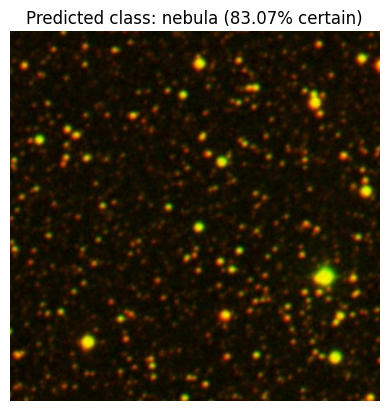

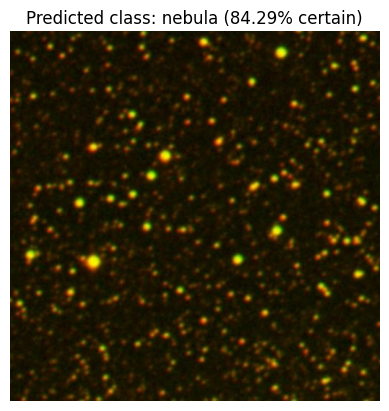

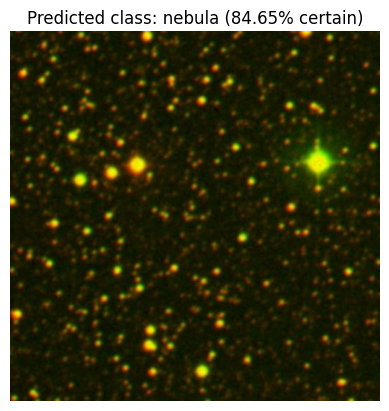

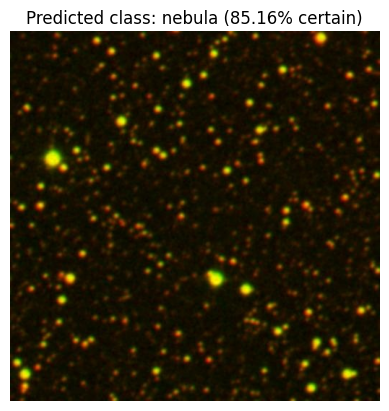

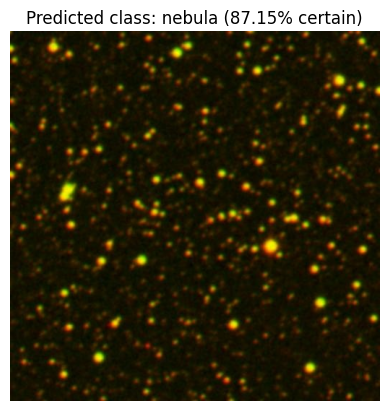

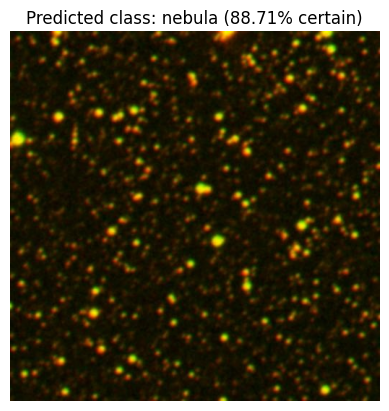

In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os 

batch_size = 8

def preprocess_input(img):
    img = cv2.resize(img, (512, 512))
    img = img / 127.5 - 1
    return img

# Load the saved model with the best validation accuracy
model = tf.keras.models.load_model("nebula_best2.h5")

# Define the data generator for the test images
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    'image_data_nebula',
    target_size=(512, 512),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

class_names = ['nebula', 'other']

# Get the predicted labels for the test set
test_predictions = model.predict(test_generator)
test_predicted_labels = np.argmax(test_predictions, axis=-1)

# Get the true labels for the test set
test_true_labels = test_generator.classes

# Create a list of positive class image filenames and predicted labels
positive_class_index = 0
positive_filenames = [filename for i, filename in enumerate(test_generator.filenames) if test_true_labels[i] == positive_class_index]
positive_indices = [i for i, filename in enumerate(test_generator.filenames) if filename in positive_filenames]
positive_predicted_labels = test_predicted_labels[positive_indices]

# Print out the class indices
print(test_generator.class_indices)

# Plot each positive image with its calculated class and percentage of certainty
for i, filename in enumerate(positive_filenames):
    image = cv2.imread(os.path.join(test_generator.directory, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predicted_class = positive_predicted_labels[i]
    certainty = round(test_predictions[:, test_generator.class_indices['images']][positive_indices[i]] * 100, 2)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted class: {class_names[predicted_class]} ({certainty}% certain)")
    plt.show()